# Estimating Missing Political Data - A Review of Previous Methods Applied to something useful - Or clever ways to use machine learning techniques for pre/post processing

Today's lab will focus on handling missing data, something we haven't had a ton of practice with. We will review some of the previous techniques covered in the immersive course thus far, but utilize it to something that we probably haven't really discussed much of: how to handle missing data -in depth. 

In general this topic is probably way more on the "art" in the science/art spectrum in the world of data science, but there are some well-established ways to deal with and impute missing data, depending on what you want to accomplish in the end (increase the power, remove NaNs, impute with a numerical/label to prevent errors from your ML algorithms etc.). 
	
Our overall goal today will be to show there is some kind of "functional relationship" between the "missingness" of the data, and features found in our data. By doing this, we can categorize the kind of "missingness" we are dealing with for a particular data-set.

We'll briefly cover the 3 types of "missingness" and go straight to coding from there.


# Types of "Missingness" 

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Types of "Missingness"
| Type  | Description  | 
|---|---|
 | Missing Completely at Random  | This is basically the best scenario, all NaN, NA, or blanks are distributed totally "at random" can be safetly omitted  |
 | Missing at Random  | This is less strong, but is "random" given the sample you are using. This is what we're aiming at for our analysis, functionally, we want to show that our missing data isn't dependent on data we haven't observed or accounted for in our data set   | 
 | Missing not at Random  | "There is a data generating process that yields missing values". Basically, it means there is some "pattern" to the 'missingness' |

# Introducing the Inclusion Indicator 

As stated, the type of “missingness” we are most concerned about is the last row, "Missing not at Random". And as good Data Scientist, we understand what "data generating process" really means: We can make an equation of sorts to "model" the “missingness” in our data set. If we can convincingly show that this model accounts for "most" (again we're not being stringent statisticians so that word will be left up to you to define for the moment) of the observable variation, we can be (relatively) well-at-ease that our "missingness" isn't functionally related to some features we don't have control/accounted/recorded in our data.

Before we move forward, we have to define the "inclusion indicator". We say I is an inclusion indicator if : $$\begin{array}{cc}
  I=\{ & 
    \begin{array}{cc}
      1 & x: missing \\
      0 & x: \neg{missing} \\
    \end{array}
\end{array} $$

Simple enough? Let's read on, and maybe we'll see how Bayesian analysis slips its slimy tenticles into seemingly simple things.


# Loading up data with missing values

We are going to load up our familiar polling data from our previous labs. However we will take the analysis much broader this time, and we will be using a version of the data set where we have not removed missing values... because after all, that's the point of this entire lab! 

So load up the data and the libraries we will need to get started!


#### Loading the data 

In [1]:
from __future__ import division
import os
import math
import pylab as py
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

polls = pd.read_csv('../CSV/polls.csv')
polls.head(3)

,Unnamed: 0,org,year,survey,bush,state,edu,age,female,black,weight
0,1,cbsnyt,1,9152,1.0,7,2,2,1,0,1403
1,2,cbsnyt,1,9152,1.0,33,4,3,0,0,778
2,3,cbsnyt,1,9152,0.0,20,2,1,1,0,1564


#### Problem 1 - Construct the Inclusion indicator and append the column to the table 

In [2]:
cols_to_drop = ['year', 'survey', 'female', 'black', 'weight', 'org', 'Unnamed: 0']
for col in polls.columns:
    if col in cols_to_drop:
        polls = polls.drop(col, axis=1)

Remember to delete extraneous columns for our purposes: year, survey, female, black, and weight. Also build an 'inclusion' indicator column that will be 1 when bush is missing a value, and 0 otherwise.

In [3]:
polls['inclusion_indicator'] = np.where(polls.bush.isnull(), 1, 0)

In [4]:
polls.head(10)

,bush,state,edu,age,inclusion_indicator
0,1.0,7,2,2,0
1,1.0,33,4,3,0
2,0.0,20,2,1,0
3,1.0,31,3,2,0
4,1.0,18,3,1,0
5,1.0,31,4,2,0
6,1.0,40,1,3,0
7,1.0,33,4,2,0
8,0.0,22,4,2,0
9,1.0,22,4,3,0


#### Problem 2 - Prepare your data by converting it into numpy arrays

Some of our ML work will be better suited if the input data is contained in a numpy container (and as I'll be saying many times throughout the week - although Pandas is a great set of methods with awesome data containers/types, numpy is often the framework real hardcore machine learning is developed on, so it's best you start to get a taste of numpy as well as Pandas. Please go ahead and convert the data into that structure now.

In [5]:
from sklearn import preprocessing
X = polls.drop('inclusion_indicator', axis=1)
X = X.drop('bush', axis=1)
y = polls.inclusion_indicator

#### Problem 3 - Split the data  70/30 train/test

Split the data in the ordinary way, making sure you have a 70/30 split.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

# Wait... how the hell can we tell if something is "Missing not at random"? 

That's a real good question, and surprisingly, there isn't much clarity on this front. Although recall, above that I mentioned that one way is to understand "how much" of the variation in your data your model is accounting for. We'll do some preliminary work on that front here, but I'm going to ask you to think deeper ask yourself: 

1. How can I apply what I've learned in Regressions to this problem? 
2. What are other metrics I could utilize to account for variation in data outside of regressions? 

So one possible approach we've strongly pointed towards is to construct regression models with the inclusion indicator as a target, and see what sort of performance you can get out of those family of techniques. 

Let's try to throw a bunch of things at this problem and see what makes sense (or see what we get).


In [7]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Using Logistic Regression to model the "missingness"

#### Problem 4 - Build a classical logistic regression to model the inclusion indicator as a target

In [8]:
# This is my favorite logistiic implementation, very simple, close to R's lm. 
import statsmodels.formula.api as sm
inclusion_lm = sm.Logit(y_train, X_train).fit()
inclusion_lm.summary()

Optimization terminated successfully.
         Current function value: 0.409994
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     inclusion_indicator   No. Observations:                 9480
Model:                           Logit   Df Residuals:                     9477
Method:                            MLE   Df Model:                            2
Date:                 Tue, 25 Oct 2016   Pseudo R-squ.:                 0.01810
Time:                         16:09:42   Log-Likelihood:                -3886.7
converged:                        True   LL-Null:                       -3958.4
                                         LLR p-value:                 7.697e-32
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
state         -0.0065      0.002     -3.635      0.000        -0.010    -0.003
edu           -0.4712      0.022    -21.756      0.000        -0.514    -0.429
age           -0.1648      0.022     -7.417      0.000        -0.208    -0.121
==============================================================================
"""

In [9]:

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Problem 5 - Build a vector of prediction from the trained model

In [10]:
y_pred_logreg = inclusion_lm.predict(X_test)

# Using K-Nearest Neighbor for imputing missing data

#### Problem 6 - Build a K-NN model (k = 5), to model the inclusion indicator 

The point of this model isn't really to shed more light on the "missingness", but rather to actually impute values into our column of data that contains missing values. Still, it's a good exercise to go through. After you've done the imputation, take a random subset of these imputed values and think about the results, is doing this a good way to fill in values? Would it be easier to do something simpler i.e. take the average for numerical data, or just select some label as fill-in for categorical data?

In [11]:
from sklearn.neighbors import KNeighborsClassifier
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)


# Imputing with Random Forest

#### Problem 7 - Build a Random forest to model the inclusion indicator 

Similar to the KNN, this is more about actually doing the imputation. However still a good review/exercise, compare your results with the KNN. How can we objectively measure relative performance? 

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer

forest = RandomForestClassifier(n_estimators=1000)
forest.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

# A Brief Aside - Reviewing Bayesian Logistic Regression and using it for imputation

> To the instructor. This decision was made as I looked through the curriculum and saw that PyMC was the better choice cause of it's attachment to several key projects, including Theano. I feel that PyMc is also much more 'natural' as a library and is just easier to use. I recommended to Jeff we make the change and he agreed. You may want to look over the code and dedicate some time to going through basic method calls for PyMC. Since they have done this in PyStan, and there are very clear equivalences between the two, they should be able to pick this up much faster than just seeing it without any context the first time around. You may want to also go over the difference between deterministic and stochastic function specifications

We are going to step away from PyStan and try our hand with PyMC for the rest of the Bayesian section. PyStan is an important tool, and is useful since it also has cross-platform integration with R. However, for purposes of ease-of-use, power, and expandability, PyMC, the latest version of which is integrated with the Theano Deep-Learning system, is a better choice. It's also syntactically closer to what you'd be use to in scikit-learn and other Python/R method-calls. 

Recall that we need to define prior distributions in the Bayesian frameworks, so please go ahead and figure out how many coefficients/parameters you will have, and proceed to define the weights. A 'uniform' or 'uninformative' prior is appropriate for this walk-through purpose.


# A little primer into PyMC

First, you should be getting comfy with reading docs by now. However, PyMC is one of the best written docs I've come across. Strangely enough it straddles the line between coding/programming doc and basic statistical exposition. Please check out the following: 

https://pymc-devs.github.io/pymc/distributions.html , this is the section on distributions. 

For our purposes, we're going to be using only a few key methods from PyMC. This includes the distribution methods, examples given below. Please study it and note where there are some similarities with PyStan. I've annotated the example to help out. 

In [13]:
# Import relevant modules   - Example provided from PyMC docs
import pymc 
import numpy as np

# Some data      - This is just simulated data, in real life, you won't have this section as a function, but maybe a pd/numpy 
#                  data frame/array etc.
n = 5*np.ones(4,dtype=int)
x = np.array([-.86,-.3,-.05,.73])

# Priors on unknown parameters      - Note - Similar to PyStan, because it's a Bayesian analysis, we have to define the distribution
#                                     for all of our parameters. Notice there's something quotes 'alpha' that is where you put
#                                     your parameter's label. You can put anything as a label, as long as it's a string. The reason
#                                     we have a label will become clear as we work more with PyMC. Just keep in mind of it for now.
alpha = pymc.Normal('alpha',mu=0,tau=.01)
beta = pymc.Normal('beta',mu=0,tau=.01)

# Arbitrary deterministic function of parameters             - Again, defining our model's form. 
@pymc.deterministic                                          # Just put this string up for now whenever you specify your model 
def theta(a=alpha, b=beta):                                  # We'll discuss later
    """theta = logit^{-1}(a+b)"""
    return pymc.invlogit(a+b*x)

# Binomial likelihood for data
d = pymc.Binomial('d', n=n, p=theta, value=np.array([0.,1.,3.,5.]),\
                  observed=True)

Great let's start specifying our first PyMC model. We're going to define a model with 3 parameters, and 1 constant, so we'll need to specify 4 distributions, say w0 (constant), w1, w2, w3. 

For simplicity, let's just have all of these parameters be normal in the following form: 

**my_parameter = pm.Normal('my_parameter', mu = 0, tau = 0.000001, value = 0)**

Again mu is just your mean ($\mu$), and tau is just your standard deviation/scaling term ($\tau$). So we would write a standard normal as pm.Normal('standard normal', mu = 0.0, tau = 1.0, value = 0)

#### Problem 8 - Start building your Bayesian Logistic Regression by defining your coeffecient priors

In [14]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

w0 = pm.Normal('w0', 0, 0.000001, value = 0)    
w1 = pm.Normal('w1', 0, 0.000001, value = 0)   
w2 = pm.Normal('w2', 0, 0.000001, value = 0)   
w3 = pm.Normal('w3', 0, 0.000001, value = 0)   
w0.value; w1.value; w2.value; w3.value

array(0.0)

#### Problem 9 - Build your bayesian logistic regression form and run it through a Bernoulli method

Specify a simple univariate logistic regression, just pick one of your parameters and the constant. **Hint:** Think the Sigmoid function

In [15]:
@pm.deterministic
def bayesian_logistic(w0=w0, w1=w1, w2=w2, w3=w3, x1 = X_train['age'], x2 = X_train['state'], x3 = X_train['edu']):
    return 1.0 / (1.0 + np.exp(w0 + w1*x1))

observed = pm.Bernoulli('observed', bayesian_logistic, value = y_train, observed=True)
observed

<pymc.distributions.Bernoulli 'observed' at 0x7f1d119b1fd0>

#### Problem 10 - Go ahead and push through your Bayesian model through the computation segment by calling the Monte-Carlo Markov Chain procedure

Similar to PyStan, you will now have to push your model through the MCMC procedure. Since this is the first time you're seeing it, I've included the code here. Also, if you want to read up on it more checkout : https://pymc-devs.github.io/pymc/modelfitting.html

In [16]:
m = pm.MCMC(locals())
m.sample(100000, 50000, 50)


 [-----------------100%-----------------] 100000 of 100000 complete in 1128.3 sec

Plot the trace graph. Remember to use plt.show() at the end

Plotting w1
Plotting w0
Plotting w2
Plotting beta
Plotting alpha
Plotting w3
Plotting theta_0
Plotting theta_1
Plotting theta_2
Plotting theta_3


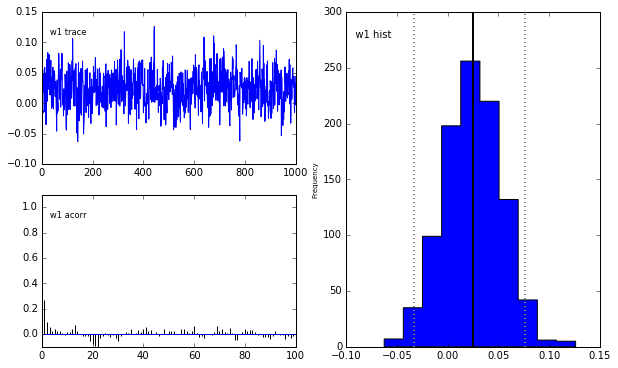

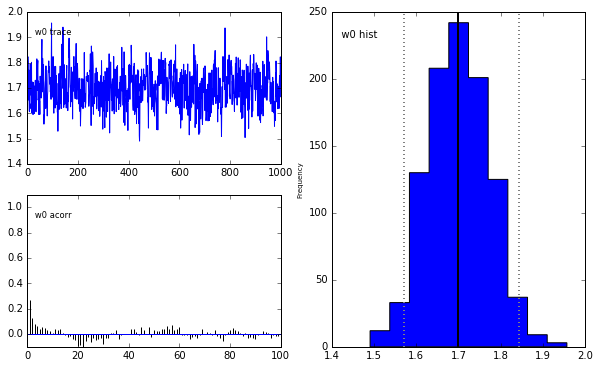

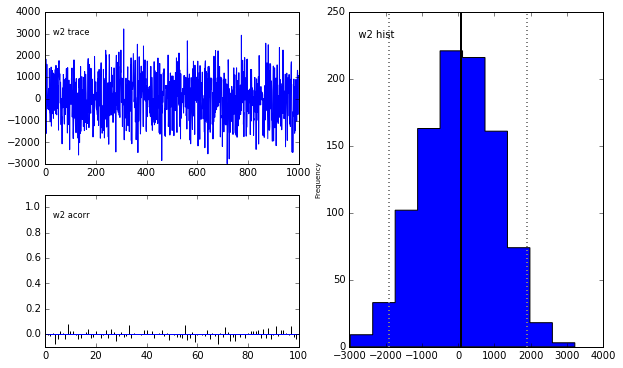

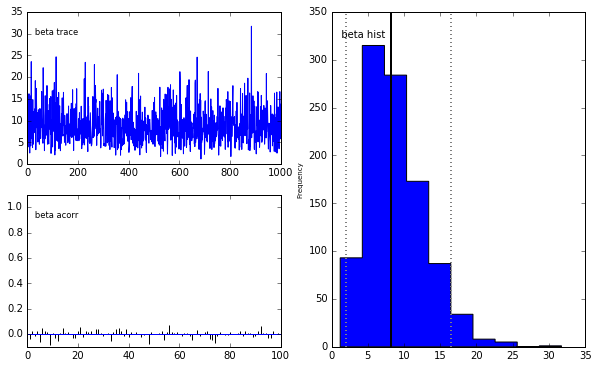

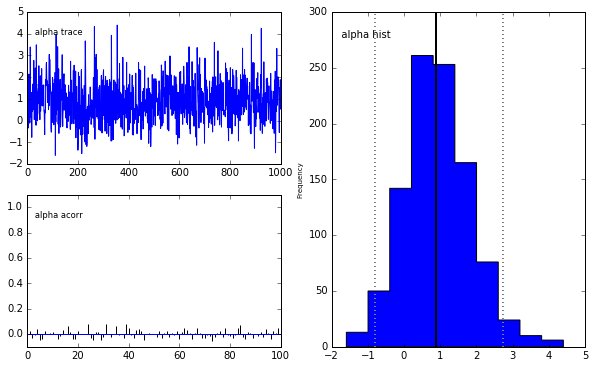

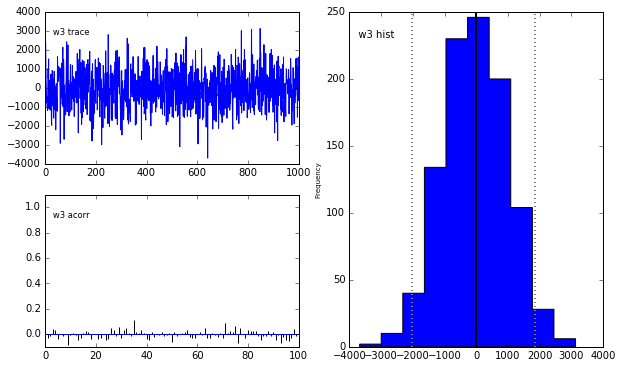

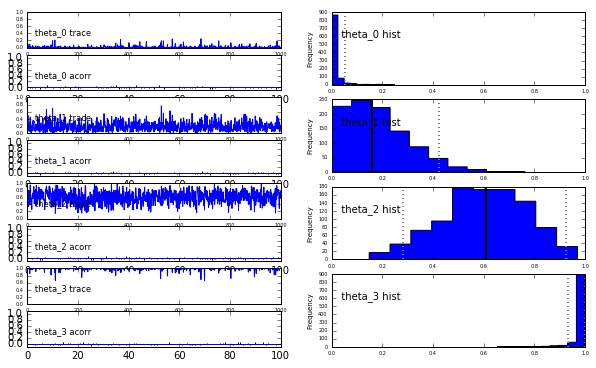

In [20]:
%matplotlib inline
pm.Matplot.plot(m)
plt.show()

# Doing some basic comparisons of results and forecasting efficaciousness

So we need to compare our results, construct ROC scores for each of the 3 methods 

Print the AUC for your non-Bayesian Logistic

In [18]:
fpr, tpr, thresholds =roc_curve(y_test, y_pred_logreg)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)


Area under the ROC curve : 0.610490


Print the AUC for Random Forest

In [21]:
random_pred = forest.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, random_pred[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc) 

Area under the ROC curve : 0.669256


Print the AUC for KNN Impute

In [22]:
fpr, tpr, thresholds =roc_curve(y_test, y_pred_knn)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)


Area under the ROC curve : 0.539260


> From my understanding determining the type of missingness is an art, so I feel the students should think about how they individually would view this exercise as a "first pass" on the "missingness" of the data, and how it will serve their future analysis (weighting observations, doing some kind of correction to account for "missingess", or nothing at all etc.)

**Open Ended Questions** So can we be fairly confident that there is some kind of functional relationship between the indicator variable and the few columns we studied in our data set? Is it obvious that there are probably other factors impacting "missingness" from this data? Which type of "missingness" are we probably in, and what does that say about the state of our missing data and how we should approach modeling on this data set in the future? What further actions can we take to augment this analysis?

# Using the Bootstrap to deal with small samples

The last thing we're going do a simple bootstrap estimation of a regression equation using the weighted least squares estimation procedure. 

Reference for weighted least squares in docs: 
http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.WLS.html

Reference for the gamma method in numpy: 

http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.random.gamma.html


We're goign first define an empty numpy array with 1000 rows and 4 columns. Remember, both in Python and R, building an empty container/structure before populating it with values is often more effecient with respect to run-time vis-a-vis iteratively adding rows/columns. Again, as we mature as data scientist, we will eventually need to think about these issues (especially as we build more complicated machine learning systems). 

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Define our feature set 
test_col_1 = X_train

# Add a constant term for our regression equation

test_col_1 = sm.add_constant(test_col_1) 
         
y = y_train
N = len(y)
M = np.empty((1000,4))

Build the Bayesian Bootstrap procedure. Peruse this paper if you'd like to understand the fundamental background for the procedure: https://projecteuclid.org/download/pdf_1/euclid.aos/1176345338. Unfortunately, I couldn't find more clearer exposition on this, but I'll cut to the chase with respect to the differences between "ordinary bootstrap" and "bayesian bootstrap", basically, we are drawing from a dirchilet distribution for the bayesian variant. 

So our aim is as follows: 

1. We want to create a vector of dirchilet draws
2. Use those draws as weights to pair with our features in a weighted least-squares procedure
3. We wish to to create a basic statistical summarization of the results (hint- look up the describe method for a pandas data-frame : double hint- it's ok to store the results of the WLS procedure to a pandas data frame). 

In [24]:
# Write a for loop that creates a vector of length 1000, each being populated by a Dirchilet draw

for b in range (0,1000):
    W = np.random.gamma(1.,1.,N) 
    W = W/np.sum(W)              
    
    result = sm.WLS(y, test_col_1 ,weights=W).fit()
    M[b,:] = np.matrix(result.params) 
    M[:,0] = M[:,1]/M[:,2]          
                                
# Put Bayesian Bootstrap results in a pandas dataframe        
BB = pd.DataFrame({'constant':M[:,0], 'edu':M[:,1], 'state':M[:,2], 'age':M[:,3]})

BB.quantile(q=[0.025, 0.05, 0.5, 0.95, 0.975])

BB.describe()

,age,constant,edu,state
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.010028,0.008320,-0.000380,-0.046039
std,0.003795,0.005355,0.000241,0.003739
min,-0.025959,-0.009591,-0.001053,-0.058963
25%,-0.012590,0.004734,-0.000534,-0.048564
50%,-0.009933,0.008331,-0.000381,-0.045919
75%,-0.007436,0.011696,-0.000218,-0.043543
max,0.004113,0.025755,0.000415,-0.031936
